# Exercise 1

My final project will involve using an autoencoder-based model to predict the presence of tumours in brain scans. Tumour presence will be encoded (Yes=1,No=0), and images are taken from MRI scans from this dataset: https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16
The notebook attached to this dataset describes image preprocessing steps, which includes centering and reshaping of image scans, as well as image normalization techniques. These techniques will be used to increase the usability of the scans. 

My model idea involves using an autoencoder to denoise the imaging data beforehand, and feeding the encoded features into other models to see the change in performance. An autoencoder consists of 2 parts, an encoder and a decoder. The encoder converts the input into a lower-dimensional embedding, while the decoder re-converts the embedding back into the original input. The autoencoder cost function is thus based on the similarity between the decoded output, and the original input. I have yet to decide on a specific architecture for the autoencoder, but it will likely involve 2-3 convolutional layers, and 2 dense layers. 

After the autoencoder is trained, the encoder section of the model will be used to create high-level features that ideally represent our original image. I will then apply various other machine learning methods (KNN, Random Forests, Logistic Regression, DNN) with the goal of predicting on these features the presence or absence of a tumour.

The attached notebook also outlines how to use transfer learning to build imaging models. Transfer learning involves using pre-trained models for a different problem, and re-fitting them to the current problem. If I can find a pre-trained autoencoder with weights for a different problem, I will use transfer learning to retrain the model for the current problem.

Here are additional resources I have been looking into:
Autoencoder tutorial by TensorFlow - https://www.tensorflow.org/tutorials/generative/autoencoder#define_a_convolutional_autoencoder
Similar model idea for a different problem - https://www.frontiersin.org/articles/10.3389/fgene.2019.00233/full
Original notebook - https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16



# Exercise 2

In [180]:
import tensorflow as tf
from autograd import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(rc = {'figure.figsize':(12,8)}) #Seaborn settings for plotting
sns.set_style("darkgrid")

from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [181]:
train_labels.shape=(1,60000)
test_labels.shape=(1,10000)
train_images=(train_images.reshape(60000,784)).T
test_images=(test_images.reshape(10000,784)).T
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)
print(train_images.dtype)
print(train_labels.dtype)

(784, 60000)
(784, 10000)
(1, 60000)
(1, 10000)
uint8
uint8


In [182]:
# compute C linear combinations of input point, one per classifier
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

# multiclass perceptron
def multiclass_perceptron(w,x,y,iter):
    # get subset of points
    x_p = x[:,iter]
    y_p = y[:,iter]

    # pre-compute predictions on all points
    all_evals = model(x_p,w)

    # compute maximum across data points
    a =  np.max(all_evals,axis = 0)        

    # compute cost in compact form using numpy broadcasting
    b = all_evals[y_p.astype(int).flatten(),np.arange(np.size(y_p))]
    cost = np.sum(a - b)

    # return average
    return cost/float(np.size(y_p))

## 2.1

In [183]:
from autograd.misc.flatten import flatten_func
from autograd import grad 

# minibatch gradient descent
def minibatch_gradient_descent(g,w,x_train,y_train,alpha,max_its,batch_size):    
    #Initialize weight container and cost history container
    num_samples=np.size(y_train)
    weight_history=[w]
    cost_history=[g(w,x_train,y_train,range(0,num_samples,1))] #Cost is computed for entire dataset
    
    for k in range(max_its):
        print('Now starting Epoch: '+str(k+1)+'/'+str(max_its))
        for i in range(0,num_samples,batch_size):
            g_batch = lambda w: g(w,x_train,y_train,range(i,i+batch_size,1)) 
            #Set g_batch to be gradient w.r.t current batch
            if(i+batch_size>num_samples):
                #If number of samples not divisible by the batch size, then for the last set subset only until final element
                g_batch = lambda w: g(w,x_train,y_train,range(i,num_samples-1))
            
            gradient = grad(g_batch)
            # evaluate the gradient
            grad_eval = gradient(w)
            # take gradient descent step for batch
            w = w - alpha*grad_eval                
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w,x_train,y_train,range(0,num_samples)))
    return weight_history,cost_history

## 2.2

In [184]:

C = np.size(np.unique(train_labels)) #No. of categories
N = train_images.shape[0] #No. of features
P = np.size(train_labels) #No. of samples
w = 0.1*np.random.randn(N+1,C) #Initialize weight vector
num_epochs=5

In [185]:
#Batch size of 200
weight_history_200,cost_history_200 = minibatch_gradient_descent(multiclass_perceptron,w,train_images,
                                                         train_labels,0.001,5,200)

Now starting Epoch: 1/5
Now starting Epoch: 2/5
Now starting Epoch: 3/5
Now starting Epoch: 4/5
Now starting Epoch: 5/5


In [186]:
#Full batch run
weight_history_full,cost_history_full= minibatch_gradient_descent(multiclass_perceptron,w,train_images,
                                                         train_labels,0.001,5,P)

Now starting Epoch: 1/5
Now starting Epoch: 2/5
Now starting Epoch: 3/5
Now starting Epoch: 4/5
Now starting Epoch: 5/5


In [187]:
costs = np.hstack([cost_history_200,cost_history_full])
model_type = np.hstack([['200']*6,['Full batch']*6])
epoch_no = np.array([0,1,2,3,4,5]*2)
costs = pd.DataFrame([costs,model_type,epoch_no]).T
costs.columns=['Cost','Batch Size','Epoch no.']

In [188]:
costs['Cost']=costs['Cost'].astype(np.float64)
costs['Epoch no.']=costs['Epoch no.'].astype(np.int32)

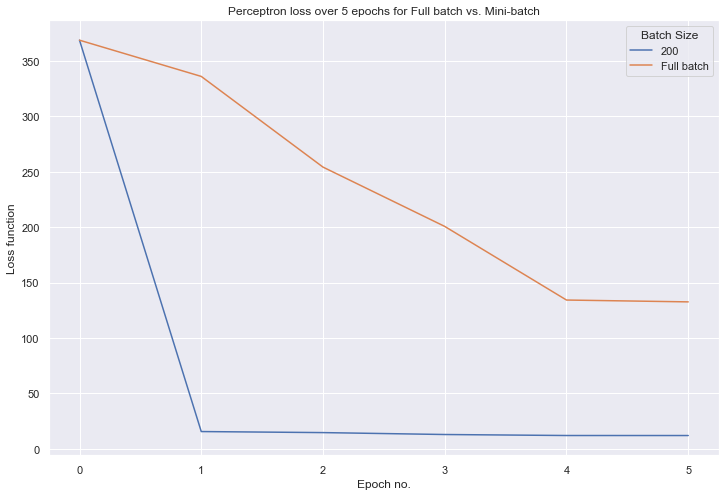

In [189]:
p = sns.lineplot(data=costs,x='Epoch no.',y='Cost',hue='Batch Size')
_=p.set(title="Perceptron loss over 5 epochs for Full batch vs. Mini-batch",ylabel="Loss function",xlabel="Epoch no.")

The plot above shows the MultiClass perceptron loss over 5 epochs for both a full batch model and a mini-batch model with batch size set to 200. The mini-batch model converges on a better minimum in fewer epochs than the full batch model, and has a lower final cost function. Thus for this problem, a batch size of 200 is provides better model performance and is more effective for converging on local minima

## 2.3

In [197]:
w_best=weight_history_200[np.argmin(cost_history_200)] #Get best weight


In [210]:
predictions=model(test_images,w_best) #Predictions using test images

In [212]:
class_predictions=np.argmax(predictions,axis=0) #Get predicted labels for the test set
incorrect_predictions=test_labels[np.where(test_labels!=class_predictions)] #Get incorrect predictions

Text(0.5, 1.0, 'Number of incorrect predictions for each digit')

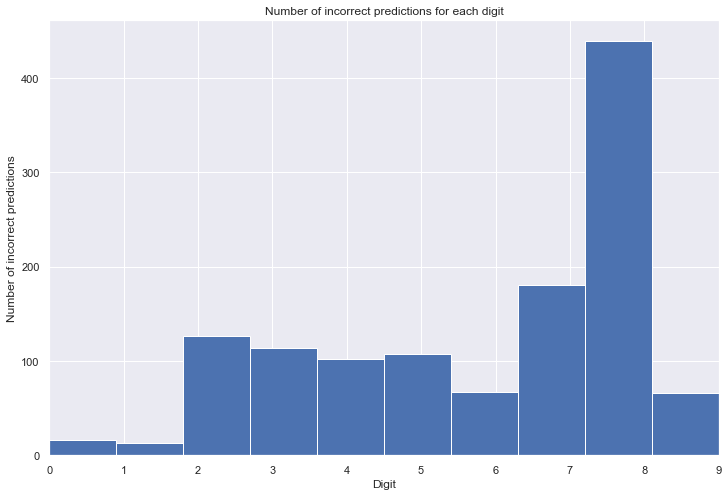

In [228]:
plt.hist(incorrect_predictions,bins=10,range=(0,9))
plt.xlim(0,9)
plt.ylabel('Number of incorrect predictions')
plt.xlabel('Digit')
plt.title('Number of incorrect predictions for each digit')

The plot above shows the number of incorrect predictions for each digit. The digit with the highest number of incorrect predictions is 8. The digit with the least number of incorrect predictinos is 0. 

# Exercise 3

In [244]:
datapath = 'Data/'

In [245]:
def model(x,C):  
    w = np.matmul(C.T,x)
    return w
def autoencoder(C):
    decoded_x = np.matmul(C,model(x,C))
    cost = np.sum((decoded_x-x)**2)/x.shape[1]
    return cost

In [246]:
def gradient_descent(g,alpha,max_its,w):
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w]     # container for weight history
    cost_history = [g(w)]    # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval

        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history,cost_history

NameError: name 'np' is not defined

In [247]:
g = autoencoder; alpha_choice = 10**(-4); max_its = 1000; w = 0.1*np.random.randn(2,1);


In [248]:
C_history,cost_history=gradient_descent(g,alpha_choice,max_its,C)

In [249]:
best_C = C_history[np.argmin(cost_history)]
encoded_x = model(x,best_C)
decoded_x = np.matmul(C,encoded_x)

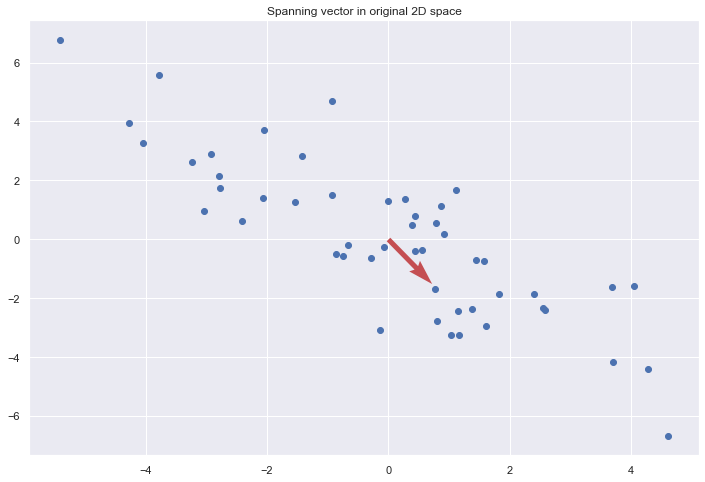

In [254]:
plt.scatter(x[0],x[1])
origin = np.array([[0],[0]]) # origin point
plt.quiver(*origin, best_C[1]*2, best_C[0]*2, color='r', scale=21)
plt.title('Spanning vector in original 2D space')
plt.show()

This plot shows the data, as well as the spanning vector in the original 2D space. The spanning vector shows a good fit with the data.

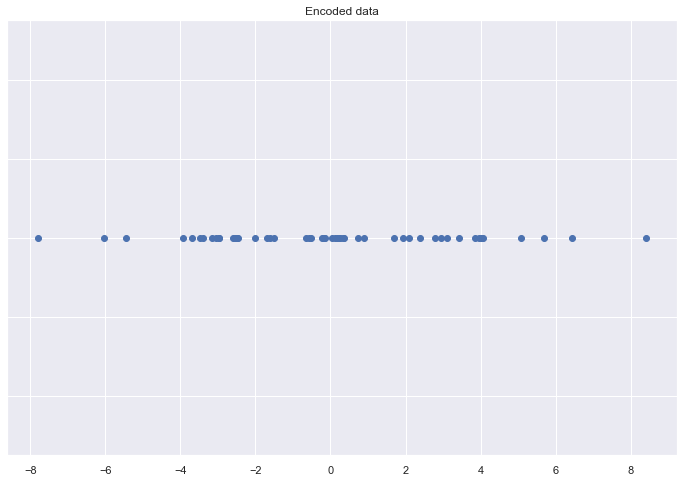

In [255]:

val = 0.
plt.plot(encoded_x, np.zeros_like(encoded_x) + val,'o',c='b')
plt.tick_params(left=False,labelleft=False)
plt.title('Encoded data')
plt.show()

This plot shows the data encoded in a single dimension.

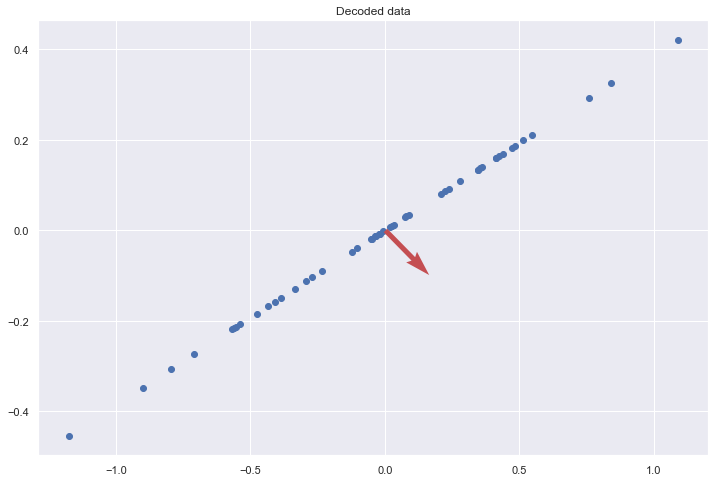

In [264]:
plt.scatter(decoded_x[0],decoded_x[1])
origin = np.array([[0],[0]]) # origin point
plt.quiver(*origin, best_C[1]*2, best_C[0]*2, color='r', scale=21)
plt.title('Decoded data')
plt.show()


This plot shows the decoded data, as well as the original spanning vector. The data forms a single line orthogonal ot the spanning vector, and some of the original encoded data has been lost. 

# Exercise 4

In [273]:
def center(X):
    X_means = np.mean(X,axis=1)[:,np.newaxis]
    X_normalized = X - X_means

    return X_normalized

def compute_pcs(X,lam):
    # create the correlation matrix
    P = float(X.shape[1])
    Cov = 1/P*np.dot(X,X.T) + lam*np.eye(X.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    D,V = np.linalg.eigh(Cov)
    return D,V

In [274]:
X_original = np.loadtxt(datapath + '2d_span_data.csv',delimiter=',') #Load data
X_centered = center(X_original) #Center data
D,V=compute_pcs(X_centered,10e-5) #Get principal components

In [275]:
X_centered.shape

(2, 50)

Text(0.5, 1.0, 'PCA Transformed data')

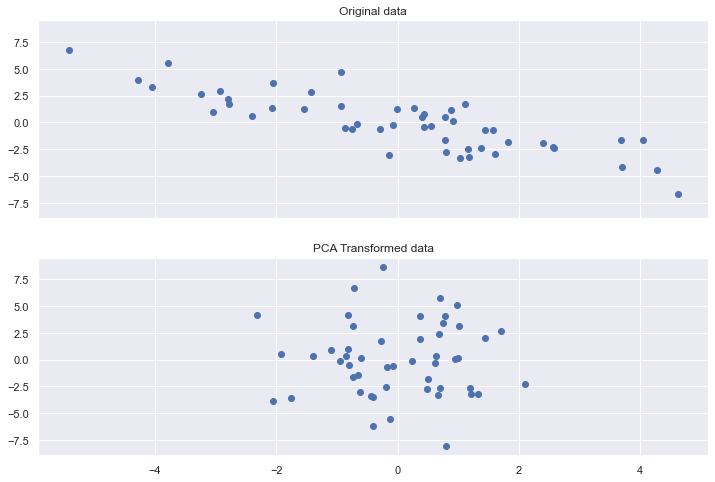

In [279]:
fig,axs=plt.subplots(2,sharex=True,sharey=True)
axs[0].scatter(X_centered[0],X_centered[1])
axs[0].set_title('Original data')
projected = np.dot(V.T,X_centered)
axs[1].scatter(projected[0],projected[1])
axs[1].set_title('PCA Transformed data')


The plots above show the 2d span data in its original space, and in the PCA transformed space. The PCA transformed space has a smaller minimum and maximum, suggesting suitable transformation has taken place.

# Exercise 5

In [280]:
def update_assignments(data,centroids):
    assignments = []
    for i in data.T:
        assignment = np.argmin(np.sum((centroids - i)**2,axis=1))
        assignments.append(assignment)
    return np.array(assignments)
        
def update_centroids(data,old_centroids,assignments):
    new_centroids = []
    for i in range(len(old_centroids)):
        points = data[:,np.where(assignments==i)]
        new_centroid = np.mean(data[:,np.where(assignments==i)[0]],axis=1)
        new_centroids.append(new_centroid)
    return np.array(new_centroids)



In [281]:
data = np.loadtxt(datapath+'blobs.dat')

In [282]:
#Run K-means for 3 centroids and over 5 iterations
K = 3
no_its = 5
centroids = np.array([[-8,4],[0,4],[-3,-1]])
assignments = update_assignments(data,centroids)
centroid_history = [centroids]
for i in range(no_its):
    centroids = update_centroids(data,centroids,assignments)
    assignments = update_assignments(data,centroids)
    centroid_history.append(centroids)

C:\Users\nicho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nicho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

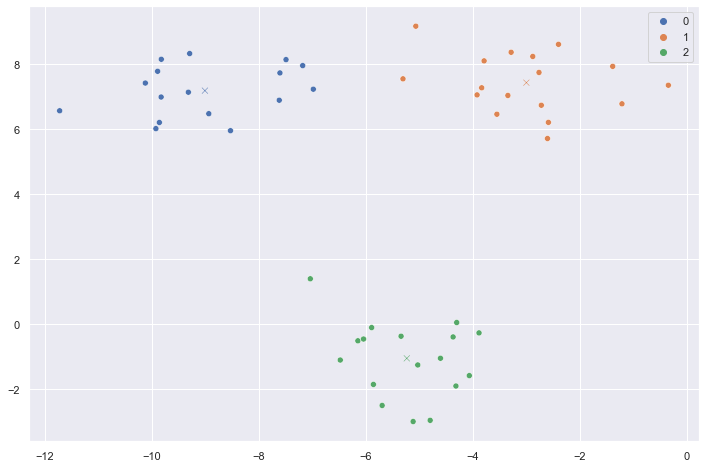

In [284]:
sns.scatterplot(data[0],data[1],hue=assignments.astype(str))
sns.scatterplot(centroids[:,0],centroids[:,1],hue=np.array(['0','1','2']),marker='x',legend=False)

The above plot shows the centroids (shown as an X) and the classes that each point has been categorized into by the K-Means clustering. Visually, the plot shows that the clustering has been successful, as the centroids fall in the center of each 'blob' and each blob's points has been categorized in the appropriate class.

In [368]:
distances = []
for K in range(1,11):
    np.random.seed(2)
    centroids = np.random.randn(K,2)*3
    assignments = update_assignments(data,centroids)
    for i in range(no_its):
        centroids = update_centroids(data,centroids,assignments)
        assignments = update_assignments(data,centroids)
    total_distance=0.0
    for i in range(len(centroids)):
        points = data[:,np.where(assignments==i)[0]]
        centroid=centroids[i]
        distance = np.sum((points.T-centroid)**2)
        total_distance+=distance
    distances.append(total_distance/len(assignments))

([<matplotlib.axis.XTick at 0x26bc08e7220>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

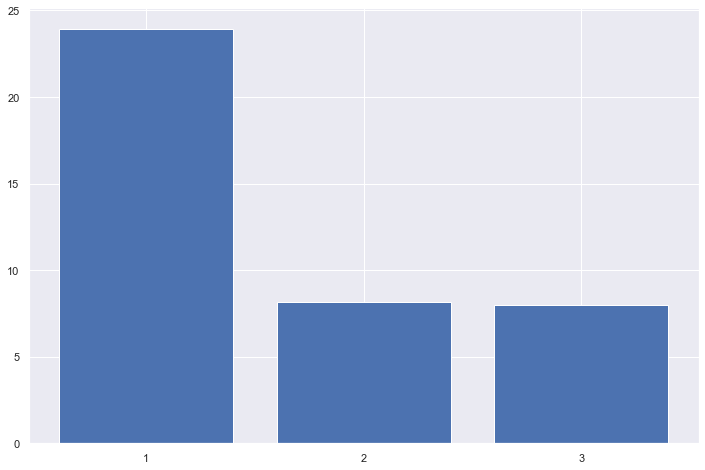

In [376]:
plt.bar(x=[1,2,3,4,5,6,7,8,9,10],height=distances)
plt.xticks([1,2,3])

The above plot shows the average intra-cluster distance for the number of centroids used. The intra-cluster distance for K-Means with more than 3 centroids returned NA, suggesting that the model could not properly converge on an appropriate clustering. According to the above plot, using 3 centroids is ideal for K-Means

# Exercise 6

In [377]:
import numpy as np
from urllib.request import urlopen
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
raw_data = urlopen(url)
dataset = np.loadtxt(raw_data, delimiter=",")
print(dataset.shape)

(1372, 5)


In [378]:
X=dataset[:,[1,3]]
Y=dataset[:,4]
print(X.shape)
print(Y.shape)

(1372, 2)
(1372,)


C:\Users\nicho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


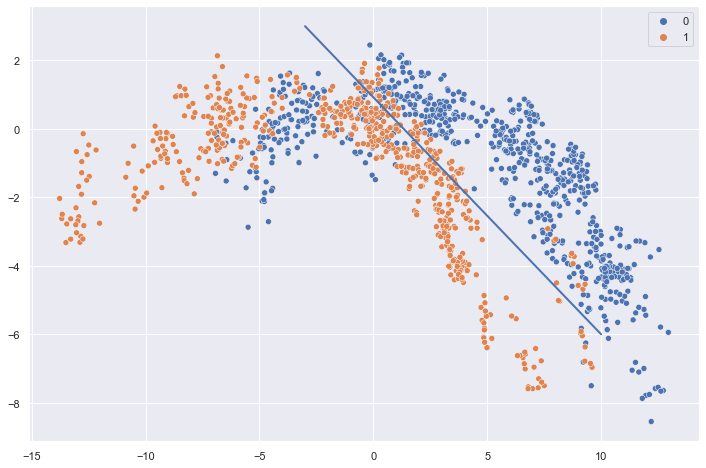

In [386]:
sns.scatterplot(X[:,0],X[:,1],hue=Y.astype(int).astype(str))
plt.plot([10, -3], [-6, 3], linewidth=2)


The above plot shows the class of each point and their position in the 2D space. The 2 classes are visually not linearly separable. An example line of separation has been plotted, however there remain a large number of points of class 0 that overlap with points of class 1 to the left of the line. 

In [387]:
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow import keras

opt = tf.keras.optimizers.SGD(learning_rate=0.15)
model = keras.Sequential()
model.add(Dense(1, batch_input_shape=(None, 2),activation='sigmoid'))
model.compile(opt,loss='binary_crossentropy',metrics=['accuracy'])
history=model.fit(X,Y,batch_size=128,epochs=400)


Epoch 1/400
11/11 [==============================] - 5s 5ms/step - loss: 0.8082 - accuracy: 0.5195
Epoch 2/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5318 - accuracy: 0.6919
Epoch 3/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5132 - accuracy: 0.7141
Epoch 4/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5224 - accuracy: 0.7268
Epoch 5/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5090 - accuracy: 0.7359
Epoch 6/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5234 - accuracy: 0.7164
Epoch 7/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5236 - accuracy: 0.7143
Epoch 8/400
11/11 [==============================] - 0s 1ms/step - loss: 0.4973 - accuracy: 0.7338
Epoch 9/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5254 - accuracy: 0.7078
Epoch 10/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5056 - accuracy: 0.7113
Epoch 11/

11/11 [==============================] - 0s 1ms/step - loss: 0.5139 - accuracy: 0.7021
Epoch 164/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5147 - accuracy: 0.7155
Epoch 165/400
11/11 [==============================] - 0s 967us/step - loss: 0.5110 - accuracy: 0.7047
Epoch 166/400
11/11 [==============================] - 0s 901us/step - loss: 0.5063 - accuracy: 0.7091
Epoch 167/400
11/11 [==============================] - 0s 1ms/step - loss: 0.4847 - accuracy: 0.7349
Epoch 168/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5315 - accuracy: 0.6909
Epoch 169/400
11/11 [==============================] - 0s 997us/step - loss: 0.5151 - accuracy: 0.7028
Epoch 170/400
11/11 [==============================] - 0s 993us/step - loss: 0.5211 - accuracy: 0.7055
Epoch 171/400
11/11 [==============================] - 0s 993us/step - loss: 0.5192 - accuracy: 0.7070
Epoch 172/400
11/11 [==============================] - 0s 985us/step - loss: 0.5120 - accuracy:

11/11 [==============================] - 0s 1ms/step - loss: 0.5193 - accuracy: 0.7042
Epoch 324/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5071 - accuracy: 0.7110
Epoch 325/400
11/11 [==============================] - 0s 998us/step - loss: 0.5081 - accuracy: 0.7113
Epoch 326/400
11/11 [==============================] - 0s 894us/step - loss: 0.5180 - accuracy: 0.7056
Epoch 327/400
11/11 [==============================] - 0s 1ms/step - loss: 0.4989 - accuracy: 0.7100
Epoch 328/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5297 - accuracy: 0.7027
Epoch 329/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5163 - accuracy: 0.7070
Epoch 330/400
11/11 [==============================] - 0s 1ms/step - loss: 0.4975 - accuracy: 0.7285
Epoch 331/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5248 - accuracy: 0.7074
Epoch 332/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5225 - accuracy: 0.7046


In [388]:
historyDF = pd.DataFrame(history.history)
historyDF['epoch']=historyDF.index+1

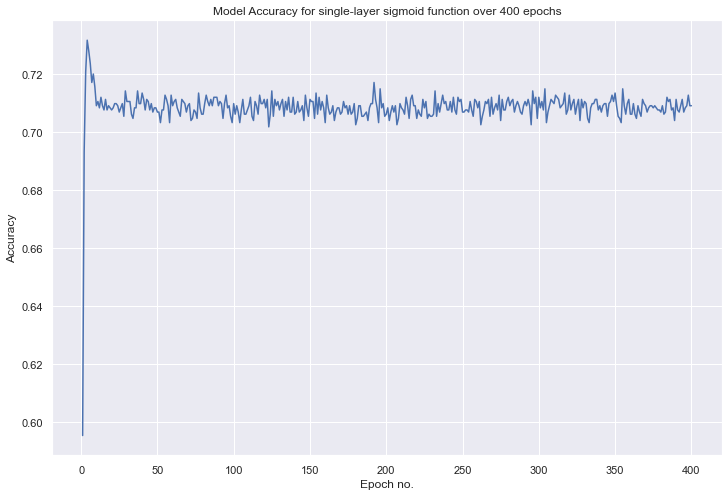

In [391]:
p = sns.lineplot(data=historyDF,y='accuracy',x='epoch')
_=p.set(title="Model Accuracy for single-layer sigmoid function over 400 epochs",ylabel="Accuracy",xlabel="Epoch no.")

The above plot shows the model's accuracy for each epoch. There is a sharp increase in accuracy after the first epoch, before the model converges on an accuracy at approximately 71%.

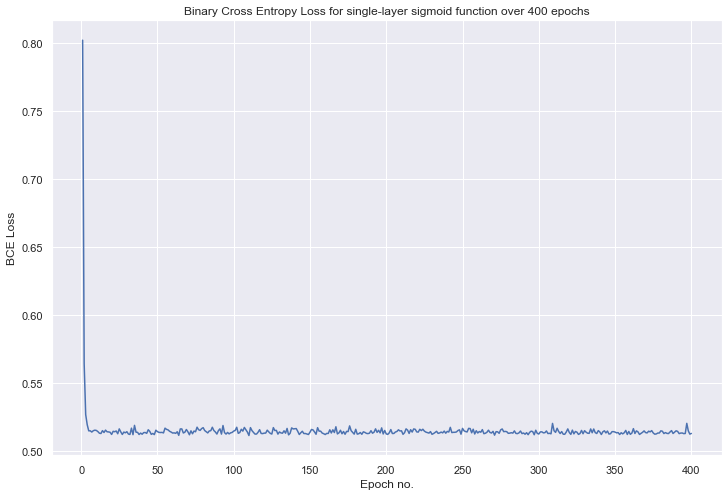

In [11]:
p = sns.lineplot(data=historyDF,y='loss',x='epoch')
_=p.set(title="Binary Cross Entropy Loss for single-layer sigmoid function over 400 epochs",ylabel="BCE Loss",xlabel="Epoch no.")

The above plot shows the model's binary cross entropy loss for each epoch. There is a sharp drop in the loss function after the first epoch, before the model begins to converge on a binary cross entropy loss of approximately 0.52.

In [12]:
print('Final Accuracy: ',str(history.history['accuracy'][-1]))

Final Accuracy:  0.7077259421348572


In [392]:
x1list = np.linspace(np.min(X[:,0])-2, np.max(X[:,0])+2, 50) # Define 50 points on the x1-axis
x2list = np.linspace(np.min(X[:,1])-2, np.max(X[:,1])+2, 50) # Define 50 points on the x2-axis
x1s,x2s=np.meshgrid(x1list,x2list)

x1,x2=x1s.flatten(),x2s.flatten()
grid = np.vstack((x1,x2)).T
y_pred = model.predict(grid)
y_preds = y_pred.reshape(x1s.shape)


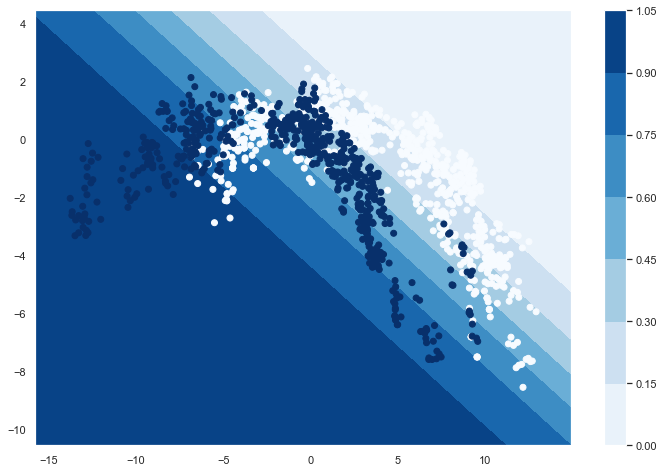

In [393]:
from matplotlib.colors import Colormap
plt.figure()
plt.contourf(x1s,x2s,y_preds,cmap='Blues')
plt.colorbar()
plt.scatter(X[:,0],X[:,1],c=Y,cmap='Blues')


Above is the contour plot for logistic regression of the 2 variables. Visually, the contour misclassifies many points, with many white points (class=0) falling in the blue zone. 

In [394]:
from tensorflow.keras.utils import to_categorical
Y_c=to_categorical(Y,2)

In [396]:
opt = tf.keras.optimizers.SGD(learning_rate=0.15)
model = keras.Sequential()
model.add(Dense(8, batch_input_shape=(None, 2),activation='sigmoid'))
model.add(Dense(2,batch_input_shape=(None,8),activation='softmax'))
model.compile(opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(X,Y_c,batch_size=128,epochs=400)


Epoch 1/400
11/11 [==============================] - 9s 3ms/step - loss: 0.8124 - accuracy: 0.5496
Epoch 2/400
11/11 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.6095
Epoch 3/400
11/11 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.6220
Epoch 4/400
11/11 [==============================] - 0s 4ms/step - loss: 0.5918 - accuracy: 0.6229
Epoch 5/400
11/11 [==============================] - 0s 6ms/step - loss: 0.5725 - accuracy: 0.6370
Epoch 6/400
11/11 [==============================] - 0s 3ms/step - loss: 0.5560 - accuracy: 0.6429
Epoch 7/400
11/11 [==============================] - 0s 2ms/step - loss: 0.5438 - accuracy: 0.6831
Epoch 8/400
11/11 [==============================] - 0s 3ms/step - loss: 0.5326 - accuracy: 0.7114
Epoch 9/400
11/11 [==============================] - 0s 3ms/step - loss: 0.5258 - accuracy: 0.6904
Epoch 10/400
11/11 [==============================] - 0s 3ms/step - loss: 0.5162 - accuracy: 0.7048
Epoch 11/

11/11 [==============================] - 0s 2ms/step - loss: 0.3466 - accuracy: 0.8370
Epoch 84/400
11/11 [==============================] - 0s 3ms/step - loss: 0.3701 - accuracy: 0.8174
Epoch 85/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3605 - accuracy: 0.8316
Epoch 86/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3538 - accuracy: 0.8305
Epoch 87/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3662 - accuracy: 0.8199
Epoch 88/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3600 - accuracy: 0.8300
Epoch 89/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3689 - accuracy: 0.8249
Epoch 90/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3756 - accuracy: 0.8085
Epoch 91/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3517 - accuracy: 0.8336
Epoch 92/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3629 - accuracy: 0.8219
Epoch 93/400


11/11 [==============================] - 0s 2ms/step - loss: 0.2994 - accuracy: 0.8650
Epoch 246/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3042 - accuracy: 0.8611
Epoch 247/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3139 - accuracy: 0.8645
Epoch 248/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3085 - accuracy: 0.8647
Epoch 249/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3040 - accuracy: 0.8608
Epoch 250/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3165 - accuracy: 0.8683
Epoch 251/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3030 - accuracy: 0.8698
Epoch 252/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3045 - accuracy: 0.8740
Epoch 253/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3088 - accuracy: 0.8611
Epoch 254/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3106 - accuracy: 0.8574
Epoc

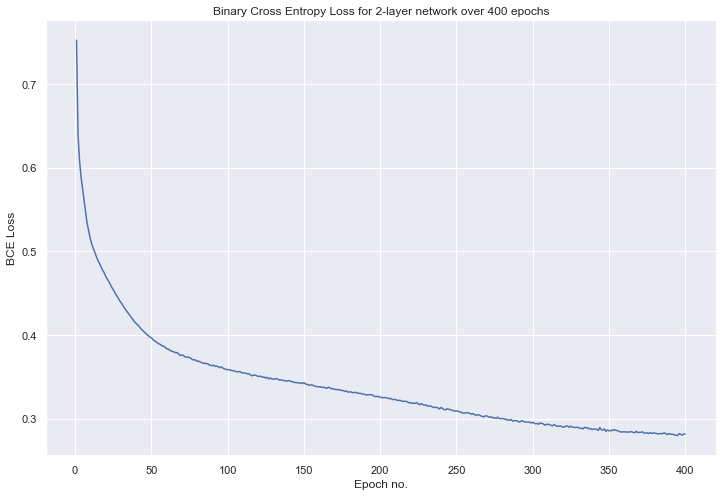

In [399]:
p = sns.lineplot(data=historyDF,y='loss',x='epoch')
_=p.set(title="Binary Cross Entropy Loss for 2-layer network over 400 epochs",ylabel="BCE Loss",xlabel="Epoch no.")

The above plot shows the 2-layer network model loss over 400 epochs. The model continues to converge, after where the logistic model stops, and has lower overall loss than the logistic functions.

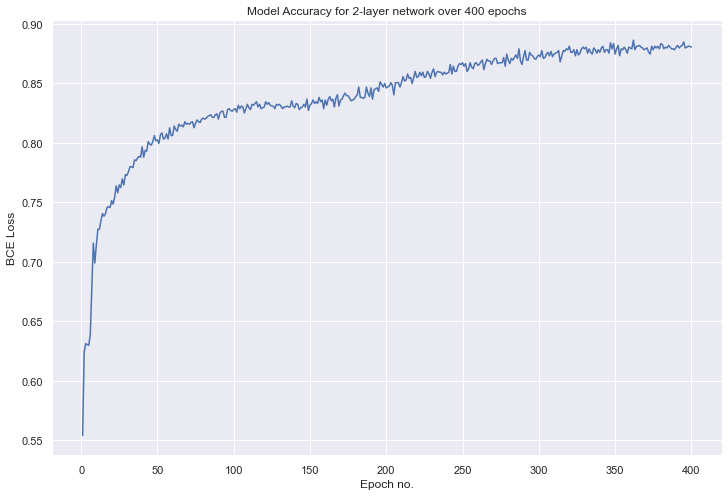

In [400]:
historyDF = pd.DataFrame(history.history)
historyDF['epoch']=historyDF.index+1
p = sns.lineplot(data=historyDF,y='accuracy',x='epoch')
_=p.set(title="Model Accuracy for 2-layer network over 400 epochs",ylabel="BCE Loss",xlabel="Epoch no.")

The above plot shows the 2-layer network model accuracy over 400 epochs. The accuracy consistently increases over the training period, and ends with an accuracy around 88%. This is significantly better than the logistic regression model, and the network is able to better converge.

In [401]:
y_pred

array([[9.9996138e-01],
       [9.9995351e-01],
       [9.9994397e-01],
       ...,
       [1.3321638e-03],
       [1.1073351e-03],
       [9.2047453e-04]], dtype=float32)

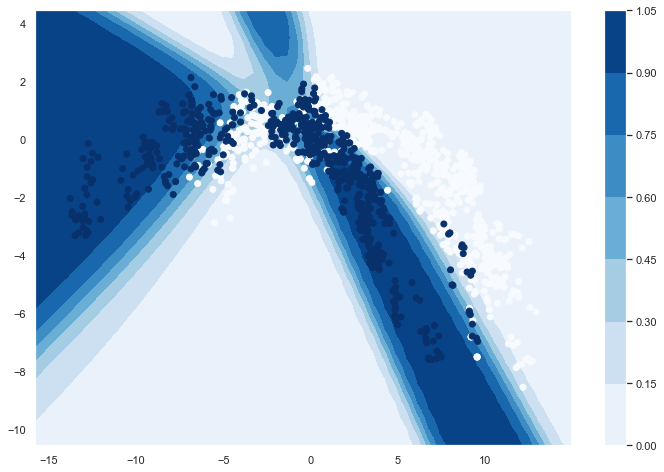

In [402]:
x1list = np.linspace(np.min(X[:,0])-2, np.max(X[:,0])+2, 50) # Define 50 points on the x1-axis
x2list = np.linspace(np.min(X[:,1])-2, np.max(X[:,1])+2, 50) # Define 50 points on the x2-axis

x1s,x2s=np.meshgrid(x1list,x2list)

x1,x2=x1s.flatten(),x2s.flatten()
grid = np.vstack((x1,x2)).T
y_pred = model.predict(grid)
y_preds = y_pred[:,1].reshape(x1s.shape)

from matplotlib.colors import Colormap
plt.figure()
plt.contourf(x1s,x2s,y_preds,cmap='Blues')
plt.colorbar()
plt.scatter(X[:,0],X[:,1],c=Y,cmap='Blues')


Above is the contour plot for neural network of the 2 variables. Visually, the contour correctly classifies the points that the logistic regression model would misclassify. Overall, the neural network shows a better visual fit than the logistic regression model.